In [1]:
import numpy as np
import pandas as pd
import os
import shutil

In [2]:
public = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/private_actual_gt.csv')
private = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/private_actual_gt.csv')
queries = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/queries.csv')
sample_subm = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/sample_submission.csv')
test = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/test.csv')
train = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/train.csv')

In [3]:
public.query_idx.value_counts()

168    65
28     65
72     65
122    59
32     59
       ..
44      1
19      1
40      1
38      1
59      1
Name: query_idx, Length: 117, dtype: int64

In [4]:
private.query_idx.value_counts()

168    65
28     65
72     65
122    59
32     59
       ..
44      1
19      1
40      1
38      1
59      1
Name: query_idx, Length: 117, dtype: int64

In [5]:
public[public.query_idx == 0]

,query_idx,database_idx
0,0,582
1,0,2427
2,0,1614
3,0,809
4,0,2165
5,0,343
6,0,4215
7,0,4551
8,0,4837
9,0,1353


In [6]:
queries

,idx
0,0
1,1
2,2
3,3
4,4
...,...
164,164
165,165
166,166
167,167


In [7]:
test

,idx,item_nm
0,3868,Кольцо уплотнительное 3&quot;
1,3512,"Винт оцинк. M6x100 10,9"
2,1526,Сальники коленвала 4RMAZG/ZY4 (комплект 2 шт)
3,5484,Карбюратор
4,4281,Прокладка крышки поддона картера TY290/295
...,...,...
2397,1101,Прокладка корпуса подшипника первичного вала (...
2398,784,Шатуны на двигатель YCD4R11G-68
2399,2598,Планка
2400,7048,Вилка 1.1/8


Train set

In [8]:
!mkdir weights
!mkdir data
!mkdir data/test
!mkdir data/queries

In [9]:
train_ = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/train.csv')
test_ = train.sample(frac=0.01, random_state=41)
test_.to_csv('./data/test.csv', index=False)
queries_ = train_.sample(frac=0.01, random_state=42)
queries_ = queries_[['idx']]
queries_.to_csv('./data/queries.csv')

In [10]:
for idx in test_['idx'].values:
    shutil.copy(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/train/{idx}.png', './data/test')
for idx in queries_['idx'].values:
    shutil.copy(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/train/{idx}.png', './data/queries')

In [11]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

from PIL import Image

from transformers import BeitFeatureExtractor, BeitModel, BeitConfig
import torch

queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')

configuration = BeitConfig()

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")

def extract_features(path, model=model):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))

    inputs = feature_extractor(img, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    feature = outputs.pooler_output
    
    feature = torch.squeeze(feature).numpy()

    return feature / np.linalg.norm(feature)

test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))
    
queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k were not used when initializing BeitModel: ['lm_head.bias', 'lm_head.weight', 'layernorm.bias', 'layernorm.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitM

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [12]:
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
6296,1.000000,4588
5654,0.989288,3447
373,0.988996,1782
4903,0.984959,1782
1045,0.984959,1782
7149,0.983926,3416
1805,0.983355,5998
4688,0.983109,6557
2035,0.983063,6557


In [13]:
idx_f = 6079
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
360,0.976889,225,6079
361,0.961319,5859,6079
362,0.955604,2607,6079
363,0.954254,1237,6079
364,0.952450,1708,6079
365,0.950633,7126,6079
366,0.949018,4422,6079
367,0.948207,1882,6079
368,0.946531,6073,6079
369,0.944622,1782,6079


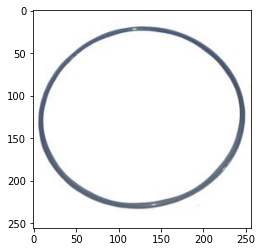

candidates:
score: [0.9768894]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


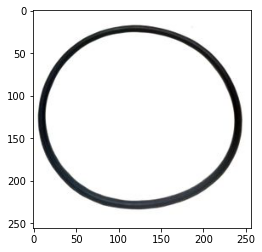

score: [0.961319]


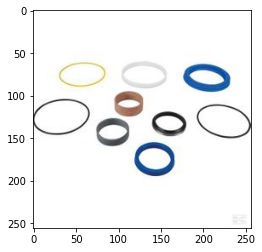

score: [0.9556043]


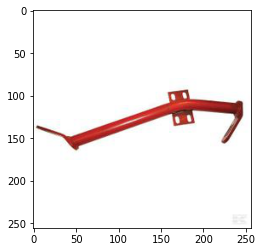

score: [0.95425415]


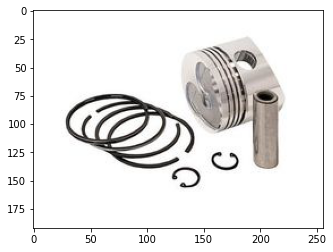

score: [0.9524498]


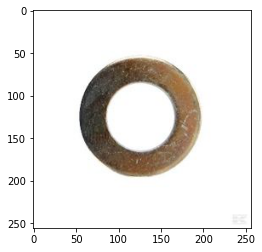

score: [0.9506333]


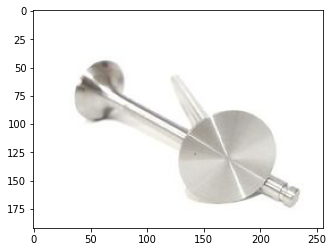

score: [0.949018]


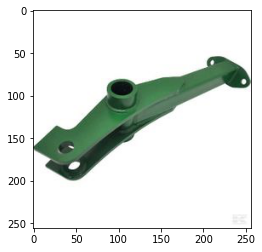

score: [0.948207]


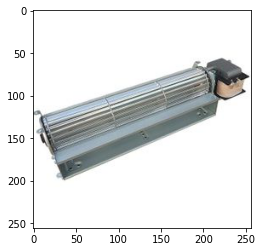

score: [0.946531]


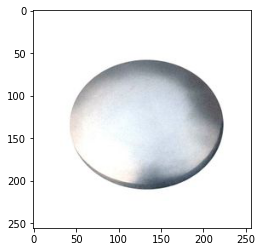

score: [0.94462204]


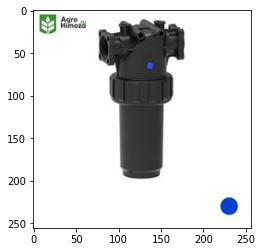

In [14]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-cup-2022-test/Zapchasti/data/train/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'../input/agrocode-data-cup-2022-test/Zapchasti/data/train/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()

### with real queries

Beit from HF

In [12]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

from PIL import Image

from transformers import BeitFeatureExtractor, BeitModel, BeitConfig
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

queries = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/queries.csv')
test = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/test.csv')

configuration = BeitConfig()

# feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
# model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k").to(device)

feature_extractor = BeitFeatureExtractor.from_pretrained("../input/beitbasepatch16224-ft-agro-code/beit-base-patch16-224_feature_extractor")
model = BeitModel.from_pretrained("../input/beitbasepatch16224-ft-agro-code/beit-base-patch16-224_fine_tuned").to(device)

def extract_features(path, model=model):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))

    inputs = feature_extractor(img, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    feature = outputs.pooler_output
    
    feature = torch.squeeze(feature).cpu().numpy()

    return feature / np.linalg.norm(feature)

test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/queries/{idx}.png'))
    
queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

Some weights of the model checkpoint at ../input/beitbasepatch16224-ft-agro-code/beit-base-patch16-224_fine_tuned were not used when initializing BeitModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2402 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Beit from timm

In [69]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 725.8 kB/s eta 0:00:00a 0:00:01


In [ ]:
import timm
print(timm.list_models(pretrained="timm"))

In [72]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from PIL import Image

import torch

import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

queries = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/queries.csv')
test = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/test.csv')

device = "cuda:0" if torch.cuda.is_available() else "cpu"


model = timm.create_model('beit_base_patch16_224_in22k', pretrained=True, num_classes=0).to(device)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)


def extract_features(path, model=model):
    img = Image.open(path).convert('RGB')
    # img = img.resize((384, 384))

    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(tensor)
        
    feature = torch.squeeze(out).cpu().numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

Downloading: "https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth" to /root/.cache/torch/hub/checkpoints/beit_base_patch16_224_pt22k_ft22k.pth


  0%|          | 0/2402 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

CLIP

In [33]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 153.5 kB/s eta 0:00:00a 0:00:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gfzljc3q
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gfzljc3q
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=3496e734b36a3f421712e3d78399740db5ff8e87d59465b883c87c238801c382
  Stored in directory: /tmp/pip-ephem-wheel-cache-zyzzmp9r/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [34]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [36]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

import torch
import clip
from PIL import Image


queries = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/queries.csv')
test = pd.read_csv('../input/agrocode-data-cup-2022-test/Zapchasti/data/test.csv')


device = "cuda" if torch.cuda.is_available() else "cpu"

# if os.path.exists('./weights/ViT-B-32.pt'):
#   model, preprocess = clip.load("./weights/ViT-B-32.pt", device=device)
# else:
#   model, preprocess = clip.load("ViT-B/32", device=device)
#   shutil.copy('/root/.cache/clip/ViT-B-32.pt', './weights')

model, preprocess = clip.load("ViT-L/14@336px", device=device)


def extract_features(path, model=model):

    image = preprocess(Image.open(path)).unsqueeze(0).to(device)

    with torch.no_grad():
      image_features = model.encode_image(image)
    
    feature = torch.squeeze(image_features).cpu().numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'../input/agrocode-data-cup-2022-test/Zapchasti/data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

100%|███████████████████████████████████████| 891M/891M [00:23<00:00, 40.2MiB/s]


  0%|          | 0/2402 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

In [13]:
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
114,0.781457,2527
126,0.752298,5736
125,0.742871,5552
37,0.701648,2646
112,0.688852,5111
...,...,...
78,0.340676,2541
74,0.324653,4754
90,0.324602,44


In [37]:
idx_f = 100
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
1000,0.770007,2705,100
1001,0.766342,540,100
1002,0.751201,6821,100
1003,0.750124,6949,100
1004,0.748938,4679,100
1005,0.747878,5574,100
1006,0.747471,5983,100
1007,0.743943,6544,100
1008,0.742938,5797,100
1009,0.740132,1561,100


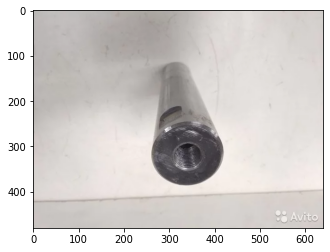

candidates:
score: [0.47755837]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


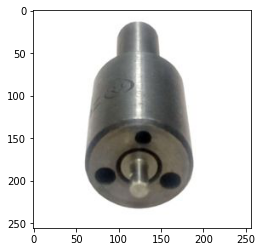

score: [0.37862122]


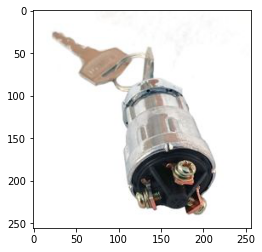

score: [0.35026205]


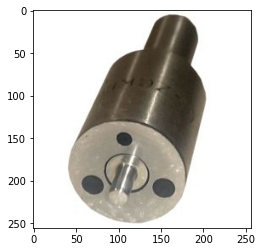

score: [0.32491755]


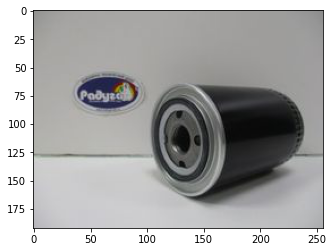

score: [0.3048399]


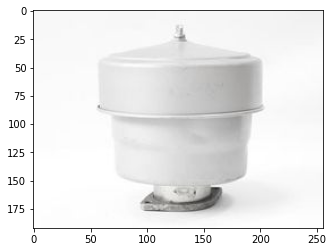

score: [0.3048399]


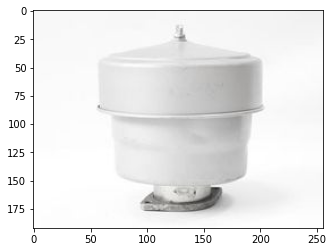

score: [0.30104268]


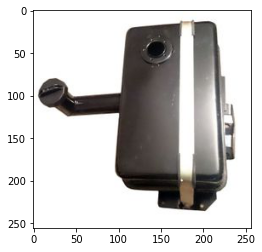

score: [0.29619145]


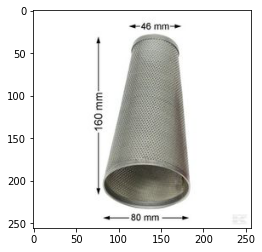

score: [0.28273094]


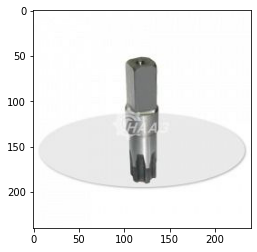

score: [0.28008312]


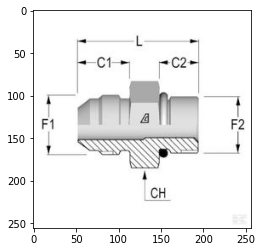

In [15]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-cup-2022-test/Zapchasti/data/queries/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'../input/agrocode-data-cup-2022-test/Zapchasti/data/test/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()

In [16]:
pd.Series(list(set(pred_data[pred_data.query_idx == idx_f]).intersection(set(public[public.query_idx == 100]))))

0       query_idx
1    database_idx
dtype: object

ground truth

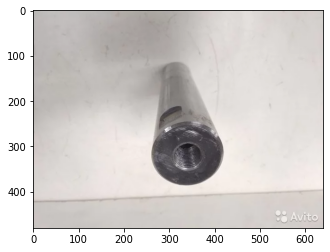

candidates:


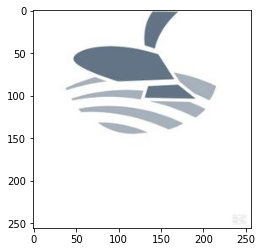

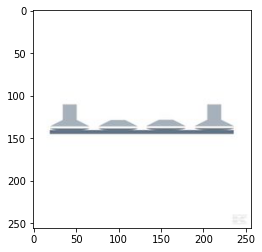

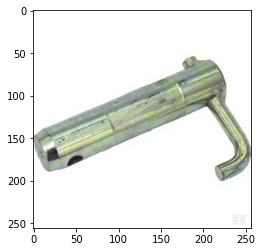

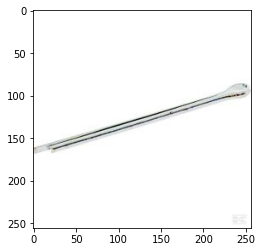

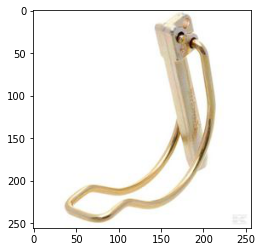

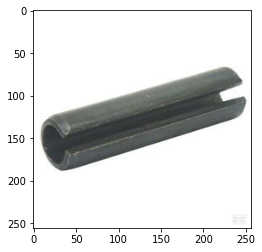

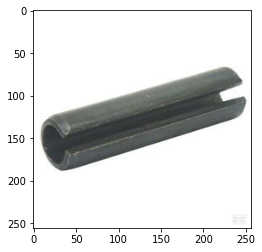

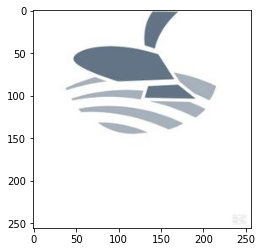

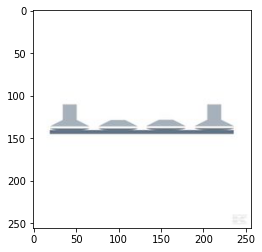

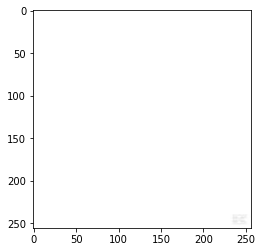

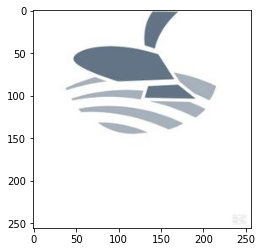

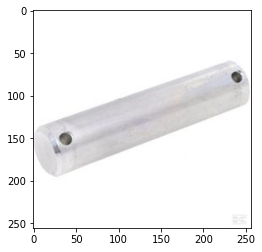

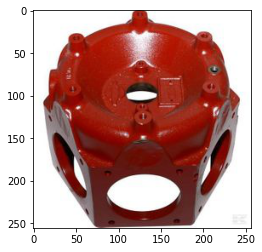

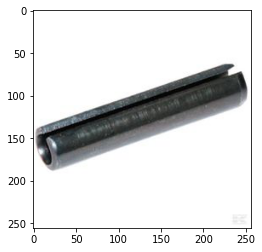

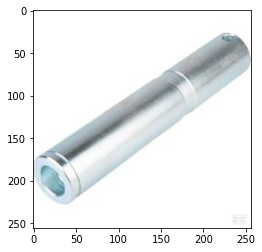

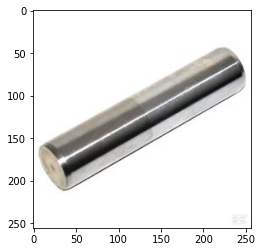

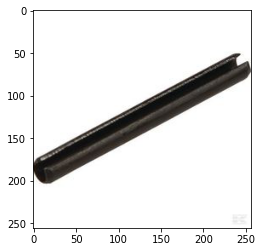

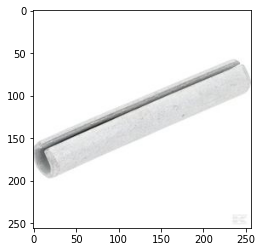

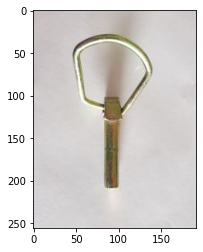

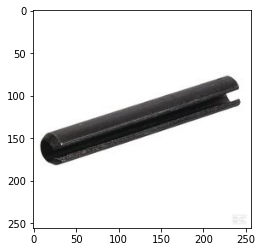

In [17]:
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-cup-2022-test/Zapchasti/data/queries/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = public[public.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'../input/agrocode-data-cup-2022-test/Zapchasti/data/test/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img2)
    plt.show()

metric

In [18]:
import pandas as pd
from sklearn.metrics import average_precision_score

def custom_map(pred_data, actual):
    
    merged = pd.merge(pred_data, actual.assign(actual=1.0),
                     on=['query_idx', 'database_idx'],
                     how='left').fillna({'actual': 0.0})
    
    unadjusted_aps = merged.groupby('query_idx').apply(
        lambda df: average_precision_score(df["actual"].values, df['score'].values)
        if df["actual"].sum()
        else 0.0
    )
    
    predicted_n_pos = merged.groupby('query_idx')["actual"].sum().astype("int64").rename()
    actual_n_pos = actual.groupby('query_idx').size().clip(upper=10)
    adjusted_aps = unadjusted_aps.multiply(predicted_n_pos).divide(actual_n_pos)
    
    return adjusted_aps.mean()


def calculate_metric(
    pred_data, 
    public_actual_data_path='data_/public_actual_gt.csv',
    private_actual_data_path='data_/private_actual_gt.csv'
):
    
    public_actual = pd.read_csv(public_actual_data_path)
    private_actual = pd.read_csv(private_actual_data_path)
    
    
    public_metric = custom_map(pred_data[pred_data.query_idx.isin(public_actual.query_idx.unique())], public_actual)
    private_metric = custom_map(pred_data[pred_data.query_idx.isin(private_actual.query_idx.unique())], private_actual)
    
    return public_metric, private_metric

In [38]:
pred_data = pd.read_csv('./data/submission.csv')
# pred_data['score'] = pred_data['score'].apply(lambda x: 0.5 if x <= 0.1 else x - 0.5)
# pred_data.score = (pred_data.score-pred_data.score.mean())/pred_data.score.std()
# pred_data.score=(pred_data.score-pred_data.score.min())/(pred_data.score.max()-pred_data.score.min())

In [146]:
# idxs = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).index
# pred_data.at[idxs, 'score'] = 1

In [41]:
calculate_metric(pred_data,
                '../input/agrocode-data-cup-2022-test/Zapchasti/data/public_actual_gt.csv',
                '../input/agrocode-data-cup-2022-test/Zapchasti/data/private_actual_gt.csv')

(0.17687790195443256, 0.2047985347985348)

first place

In [22]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 527.0 kB/s eta 0:00:0000:0100:01


In [30]:
# import clip
# from clip.clip import _MODELS, _download
import os

import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from torchvision import transforms
from tqdm.auto import tqdm

# from transformers import CLIPProcessor, CLIPVisionModel
device = "cuda"

queries = pd.read_csv("../input/agrocode-data-cup-2022-test/Zapchasti/data/queries.csv")
# train = pd.read_csv("data/train.csv")
test = pd.read_csv("../input/agrocode-data-cup-2022-test/Zapchasti/data/test.csv")

# clip_code = "ViT-L/14@336px"
# model_path = os.path.expanduser("~/.cache/clip/ViT-L-14-336px.pt")
# with open(model_path, "rb") as opened_file:
#     clip_vit = torch.jit.load(opened_file, map_location="cuda:0").visual.eval()


class BlendModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.feature_extractor = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0
        )
        # self.avg = nn.AdaptiveAvgPool1d(256)

    def forward(self, x):
        x1 = transforms.functional.resize(x, size=[224, 224]) / 255.0
        x1 = transforms.functional.normalize(
            x1,
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711],
        )

        x2 = transforms.functional.resize(x, size=[256, 256]) / 255.0
        x2 = transforms.functional.normalize(
            x2,
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711],
        )

        # x1 = self.feature_extractor(x)
        # x1 = self.avg(x1.flip([-2]))
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)

        return (x1 + x2) / 2
        #x2 = self.avg(x2.flip([-2])) * 0.5 + self.avg(x2) * 0.5
        # x2 = self.avg(x2)
        # return x2 # #(x1 * 1.1) + (x2 * 0.9)  # Idea of Gong zhen

def extract_features(path, model):
    with torch.no_grad():
        image = (
            torch.Tensor(np.moveaxis(np.array(Image.open(path).convert("RGB")), -1, 0))
            .unsqueeze(0)
            .to(device)
        )
        feature = model(image).squeeze(0).detach().cpu().numpy()
        return feature / np.linalg.norm(feature)

def get_scores(model_name):
    model = BlendModel(model_name=model_name)
    model.to(device)
    model.eval()

    N = 10

    test_embeddings = np.array([extract_features(f"../input/agrocode-data-cup-2022-test/Zapchasti/data/test/{idx}.png", model) for idx in tqdm(test.idx)])
    queries_embeddings = np.array([extract_features(f"../input/agrocode-data-cup-2022-test/Zapchasti/data/queries/{idx}.png", model) for idx in tqdm(queries.idx)])

    neigh = NearestNeighbors(n_neighbors=N, metric="cosine")
    neigh.fit(test_embeddings)

    distances, idxs = neigh.kneighbors(queries_embeddings, N, return_distance=True)

    pred_data = pd.DataFrame()
    pred_data["score"] = 1 - distances.flatten()
    pred_data["database_idx"] = [test.idx.iloc[x] for x in idxs.flatten()]
    pred_data.loc[:, "query_idx"] = np.repeat(queries.idx, N).values
    return pred_data


# model = CLIPVisionModel.from_pretrained("clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("clip-vit-base-patch32")

pred1 = get_scores("convnext_xlarge_in22ft1k")
#pred2 = get_scores("convnext_xlarge_384_in22ft1k")

#res = pred1.merge(pred2, on=['database_idx', 'query_idx'])

#res["score"] = res["score_x"] + res["score_y"]
#pred_data = res[['database_idx', 'query_idx', 'score']]
pred1.to_csv("./data/submission.csv", index=False)

  0%|          | 0/2402 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]